https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

In [1]:
import torch
import torch.nn as nn

import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [2]:
dataset_path = './datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 100

x_dim = 784 
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

minist_transform = transforms.Compose([
    transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, train=True, transform=minist_transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)

test_dataset = MNIST(dataset_path, train=False, transform=minist_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, **kwargs)

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True
    
    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)

        return mean, log_var

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [7]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        # epsilon = torch.randn_like(var).to(DEVICE)        
        epsilon = torch.randn_like(var)
        z = mean + var*epsilon                          
        return z
    
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5*log_var)) 
        x_hat = self.Decoder(z)

        return x_hat, mean, log_var

In [8]:
print(DEVICE)

cuda


In [9]:
encoder = Encoder(x_dim, hidden_dim, latent_dim).to(DEVICE)
decoder = Decoder(latent_dim, hidden_dim, x_dim).to(DEVICE)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [10]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

In [11]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(tqdm(train_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, x_mean, x_log_var = model(x)
        loss = loss_function(x, x_hat, x_mean, x_log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch+1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...


100%|██████████| 600/600 [00:05<00:00, 115.05it/s]


	Epoch 1 complete! 	Average Loss:  174.37129366000627


100%|██████████| 600/600 [00:04<00:00, 126.31it/s]


	Epoch 2 complete! 	Average Loss:  130.03713907945533


100%|██████████| 600/600 [00:05<00:00, 115.89it/s]


	Epoch 3 complete! 	Average Loss:  116.91492000013042


100%|██████████| 600/600 [00:05<00:00, 118.65it/s]


	Epoch 4 complete! 	Average Loss:  112.5150896676753


100%|██████████| 600/600 [00:05<00:00, 113.03it/s]


	Epoch 5 complete! 	Average Loss:  110.10659134038502


100%|██████████| 600/600 [00:04<00:00, 121.15it/s]


	Epoch 6 complete! 	Average Loss:  108.5808854438387


100%|██████████| 600/600 [00:04<00:00, 122.33it/s]


	Epoch 7 complete! 	Average Loss:  107.43462579233619


100%|██████████| 600/600 [00:05<00:00, 104.89it/s]


	Epoch 8 complete! 	Average Loss:  106.54781818982158


100%|██████████| 600/600 [00:04<00:00, 127.56it/s]


	Epoch 9 complete! 	Average Loss:  105.7836973732262


100%|██████████| 600/600 [00:05<00:00, 118.76it/s]


	Epoch 10 complete! 	Average Loss:  105.16108822321056


100%|██████████| 600/600 [00:05<00:00, 111.05it/s]


	Epoch 11 complete! 	Average Loss:  104.52801457833368


100%|██████████| 600/600 [00:04<00:00, 126.60it/s]


	Epoch 12 complete! 	Average Loss:  104.08353768324812


100%|██████████| 600/600 [00:05<00:00, 105.99it/s]


	Epoch 13 complete! 	Average Loss:  103.66179731518677


100%|██████████| 600/600 [00:05<00:00, 119.82it/s]


	Epoch 14 complete! 	Average Loss:  103.23711424966089


100%|██████████| 600/600 [00:04<00:00, 125.93it/s]


	Epoch 15 complete! 	Average Loss:  102.85685716428422


100%|██████████| 600/600 [00:04<00:00, 124.79it/s]


	Epoch 16 complete! 	Average Loss:  102.55144585050606


100%|██████████| 600/600 [00:04<00:00, 127.38it/s]


	Epoch 17 complete! 	Average Loss:  102.35650287914754


100%|██████████| 600/600 [00:04<00:00, 122.58it/s]


	Epoch 18 complete! 	Average Loss:  102.09961778745826


100%|██████████| 600/600 [00:04<00:00, 123.51it/s]


	Epoch 19 complete! 	Average Loss:  101.8910995865505


100%|██████████| 600/600 [00:05<00:00, 118.47it/s]


	Epoch 20 complete! 	Average Loss:  101.6637443916945


100%|██████████| 600/600 [00:05<00:00, 112.49it/s]


	Epoch 21 complete! 	Average Loss:  101.51963920988105


100%|██████████| 600/600 [00:05<00:00, 106.95it/s]


	Epoch 22 complete! 	Average Loss:  101.36188342876147


100%|██████████| 600/600 [00:05<00:00, 103.97it/s]


	Epoch 23 complete! 	Average Loss:  101.22926787158285


100%|██████████| 600/600 [00:05<00:00, 106.15it/s]


	Epoch 24 complete! 	Average Loss:  101.07618927052901


100%|██████████| 600/600 [00:05<00:00, 100.33it/s]


	Epoch 25 complete! 	Average Loss:  100.89349659914963


100%|██████████| 600/600 [00:04<00:00, 120.30it/s]


	Epoch 26 complete! 	Average Loss:  100.8166830296588


100%|██████████| 600/600 [00:04<00:00, 120.33it/s]


	Epoch 27 complete! 	Average Loss:  100.67808531797787


100%|██████████| 600/600 [00:04<00:00, 121.88it/s]


	Epoch 28 complete! 	Average Loss:  100.56990284914963


100%|██████████| 600/600 [00:05<00:00, 119.85it/s]


	Epoch 29 complete! 	Average Loss:  100.41501204807491


100%|██████████| 600/600 [00:04<00:00, 128.13it/s]

	Epoch 30 complete! 	Average Loss:  100.41870405754382
Finish!!


In [18]:
import matplotlib.pyplot as plt

In [12]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)

        break

In [15]:
import matplotlib.pyplot as plt


def show_image(x, idx):
    x = x.view(batch_size, 28, 28)
    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

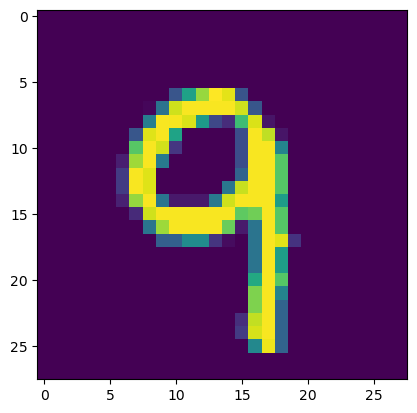

In [16]:
show_image(x, 0)

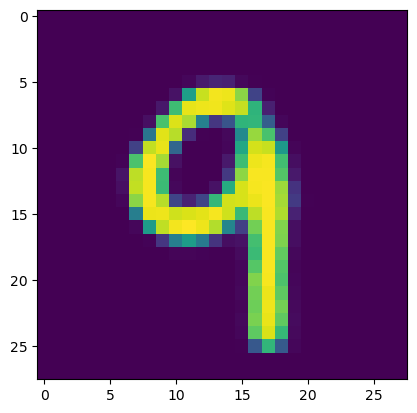

In [17]:
show_image(x_hat, 0)